# Introduction
Building a 3D CNN to predict the presence of viral pneumonia in CT scans

In [1]:
import os
import zipfile 
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import nibabel as nib
from scipy import ndimage

In [30]:
import random
import matplotlib.pyplot as plt

# The MosMedData 
Consists of lung CT scans with COVID-19 related findigs as well as without such findings

In [3]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1045162547/1045162547 [==============================] - 1061s 1us/step


In [3]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    
    return scan

def normalize(volume):
    min_scale, max_scale = -1000, 400
    
    volume[volume < min_scale] = min_scale
    volume[volume > max_scale] = max_scale
    
    volume = (volume - min_scale) / (max_scale - min_scale)
    volume = volume.astype("float32")
    
    return volume

def resize_volume(img):
    
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    img = ndimage.rotate(img, 90, reshape=False)
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    
    return img

def process_scan(path):
    
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    
    return volume

In [4]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x) 
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: ", len(normal_scan_paths))
print("CT scans with abnormal lung tissue: ", len(abnormal_scan_paths))

CT scans with normal lung tissue:  100
CT scans with abnormal lung tissue:  100


In [23]:
# %%timeit  -n 1 -r 1
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print("Number of samples in train and validation are: ", x_train.shape[0], 
      "and ", x_val.shape[0], "respectively")

Number of samples in train and validation are:  140 and  60 respectively


In [24]:
x_train.shape

(140, 128, 128, 64)

## Data Augmentation

In [27]:
@tf.function
def rotate(volume):
    
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [28]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train)).map(train_preprocessing)
    .batch(batch_size).prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val)).map(validation_preprocessing)
    .batch(batch_size).prefetch(2)
)

2023-06-01 22:48:25.313278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 587202560 exceeds 10% of free system memory.


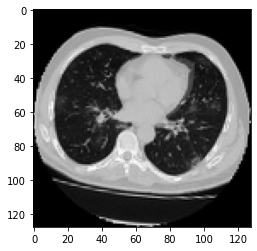

In [32]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]

plt.imshow(np.squeeze(image[:, :, 30]), cmap='gray')

## The Network

In [37]:
def get_model(width=128, height=128, depth=64):
    
    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(units=1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='3dcnn')
    return model

In [38]:
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, 
    staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5",
    save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
70/70 - 20s - loss: 0.6987 - acc: 0.5857 - val_loss: 1.2706 - val_acc: 0.5000 - 20s/epoch - 286ms/step
Epoch 2/50
70/70 - 19s - loss: 0.6375 - acc: 0.6143 - val_loss: 1.9509 - val_acc: 0.5000 - 19s/epoch - 276ms/step
Epoch 3/50
70/70 - 19s - loss: 0.6506 - acc: 0.6000 - val_loss: 1.9253 - val_acc: 0.5000 - 19s/epoch - 275ms/step
Epoch 4/50
70/70 - 19s - loss: 0.6057 - acc: 0.6929 - val_loss: 1.7223 - val_acc: 0.5000 - 19s/epoch - 276ms/step
Epoch 5/50
70/70 - 19s - loss: 0.6742 - acc: 0.5857 - val_loss: 0.6259 - val_acc: 0.6500 - 19s/epoch - 278ms/step
Epoch 6/50
70/70 - 19s - loss: 0.6366 - acc: 0.6714 - val_loss: 1.3662 - val_acc: 0.5000 - 19s/epoch - 275ms/step
Epoch 7/50
70/70 - 19s - loss: 0.6512 - acc: 0.6143 - val_loss: 1.7605 - val_acc: 0.5000 - 19s/epoch - 277ms/step
Epoch 8/50
70/70 - 19s - loss: 0.6298 - acc: 0.6357 - val_loss: 0.5896 - val_acc: 0.6167 - 19s/epoch - 278ms/step
Epoch 9/50
70/70 - 19s - loss: 0.5909 - acc: 0.6929 - val_loss: 0.7416 - val_acc: 0.6500

## Vizualization

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])